In [1]:
#!pip install fastbook --upgrade --force-reinstall


In [2]:
#hide
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

fastbook function:


Test search function:

In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [5]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [8]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/grizzly.jpg')

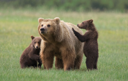

In [9]:
im = Image.open(dest)
im.to_thumb(128, 128)


Create bear categories:

In [10]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

In [12]:
fns = get_image_files(path)
fns

(#526) [Path('bears/black/386d5927-23a2-4b85-a84d-ac9a45b1b7bd.jpg'),Path('bears/black/889d7a4f-9974-4684-ae07-6db636f53fdb.jpg'),Path('bears/black/799f7389-180b-4b69-af62-5b6a8ffac4a9.jpg'),Path('bears/black/26fcaacb-84c5-402e-9a44-8568e7d3f188.jpg'),Path('bears/black/9ee7934d-afec-4854-a0c7-dfc683333028.jpg'),Path('bears/black/5c11d7aa-984c-43e3-aa45-ab631196c408.jpg'),Path('bears/black/c1edc044-f728-45ea-91e5-245667dfcd07.jpg'),Path('bears/black/9f11e376-bcdc-4a3b-aebb-f1e1000d43c7.jpg'),Path('bears/black/175c1e80-8860-47c5-8416-c370782ec0a2.jpg'),Path('bears/black/f055a6c5-ce4b-469c-9c1d-7f89a7335d37.jpg')...]

In [13]:
failed = verify_images(fns)
len(failed)

0

In [14]:
failed.map(Path.unlink);


Convert any 'RGBA' images to 'RGB'

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)

/home/sfturbo/anaconda3/envs/fastai/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


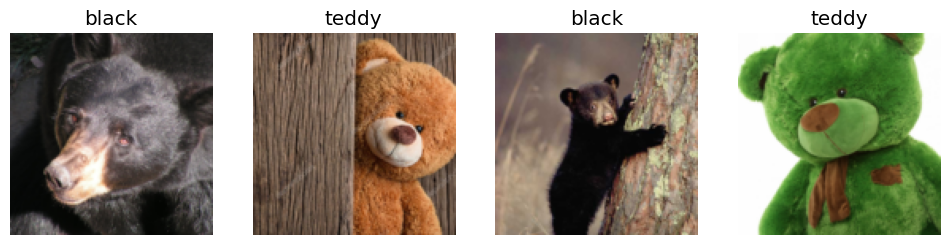

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

Alter and standardise images 

In [18]:
#bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
#dls = bears.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)

In [19]:
#bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
#dls = bears.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)

Data Augmentation :

In [20]:
#bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
#dls = bears.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1, unique=True)

Training the Model, using it to clean data

Augment the images using RandomResizedCrop.
- aug_transforms is a standard set of augmentations provided by fastai
- batch_tfms tells fastai we wish to transform the whole batch
- image size of 224px is standard for image classification

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)


Create Learner object and fine-tune it over 4 epochs

Note: training before cleaning the data can help to find problems in the data more quickly and easily.

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.163115,0.293796,0.066667,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.182300,0.204428,0.047619,00:51
1,0.165813,0.246871,0.047619,00:52
2,0.134549,0.220128,0.057143,00:49
3,0.126656,0.213500,0.047619,00:48


Use a CONFUSION MATRIX to visualise mistakes in validation

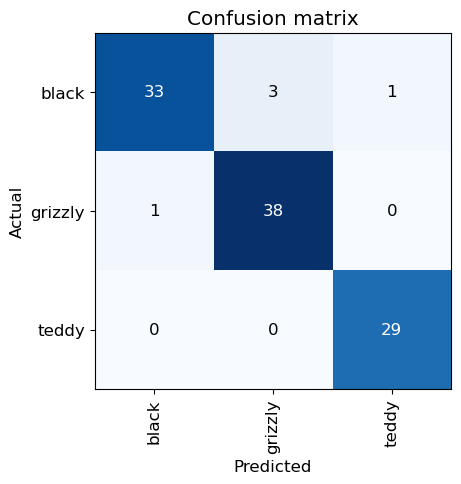

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Dealing with Loss: Loss is higher if the classification is incorrect, especially if the model is confident of the answer, or if the answer was correct but the model was not confident.

plot_top_losses method shows the images with the highest loss:

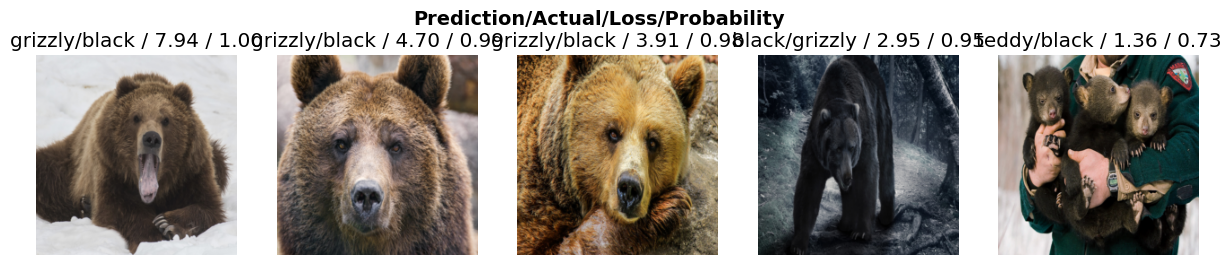

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
import ipywidgets as widgets
from IPython.display import display

w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [26]:
#!pip uninstall ipywidgets -y
#!pip install ipywidgets==7.6.5

#!jupyter nbextension install --py --symlink --sys-prefix widgetsnbextension
#!jupyter nbextension enable widgetsnbextension --py --sys-prefix

#set jupyter default image to .png
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png')


cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:

# implement cleaning

for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:

# save two parts of the model:
    # architecture and parameters
    # saves a 'export.pkl' file

learn.export()

In [29]:

# check file exists:

path = Path()
path.ls(file_exts='pkl')

(#0) []

In [30]:

# When a model is used for prediction, not training : INFERENCE

learn_inf = load_learner(path/'export.pkl')

# one image at a time:

learn_inf.predict('images/grizzly.jpg')

/home/sfturbo/anaconda3/envs/fastai/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('grizzly', tensor(1), tensor([6.7805e-05, 9.9974e-01, 1.9684e-04]))

In [31]:

# returns three things: predicted category; index of predicted category; probability of each category
# indices are based on vocab of DataLoaders:

learn_inf.dls.vocab


['black', 'grizzly', 'teddy']

In [32]:

# we can make a web app using Jupyter. We need:
# ipywidgets and Voila
# Voila allows users to use web app without Jupyter


In [33]:

# build GUI
# first, file upload widget:

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

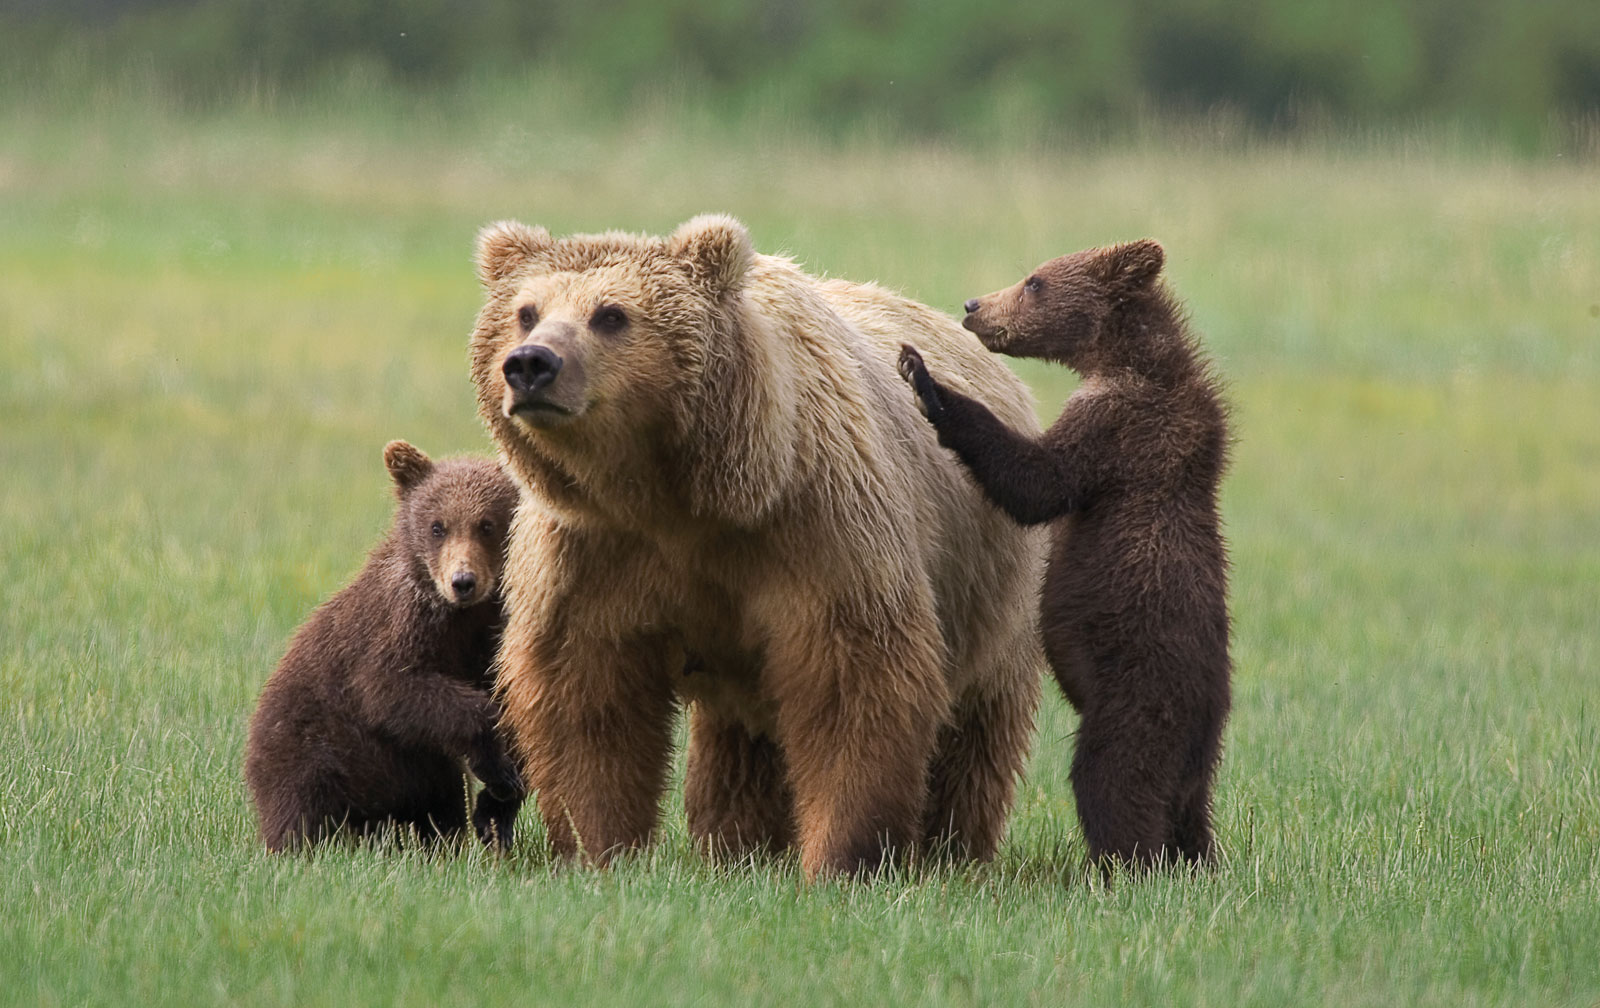

In [35]:

# create PIL from upload

img = PILImage.create(btn_upload.data[-1])
img

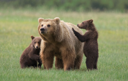

Output()

In [36]:

# use Output widget to display image:

out_pl = widgets.Output()
out_pl.clear_output()
with_out_pl: display(img.to_thumb(128, 128))
out_pl

In [37]:

# get predictions

pred, pred_idx, probs = learn_inf.predict(img)

In [38]:

# use Label to siplay them

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]: .04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability:  0.9997')

In [39]:

# button for classification:

btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:

# click event handler:
# bring together above code

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]: .04f}'

btn_run.on_click(on_click_classify)

In [41]:

# put everything in vertical box, using VBox

btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label('Select your bear'),
      btn_upload, btn_run, out_pl, lbl_pred])           


In [43]:

# convert to something deployable